# Постановка общей задачи:

На данных выборки из коллекции подержанных автомобилей, выставленных на продажу в Соединённых Штатах, нужно построить модель классификации, определяющую категорию цены подержанного автомобиля в зависимости от характеристик транспортного средства.

## Описание датасета:    

 - id: идентификатор записи  
 - url: URL записи о продаже 
 - region: регион 
 - region_url: URL региона
 - price: стоимость
 - year: год выпуска
 - manufacturer: производитель
 - model: модель
 - fuel: тип топлива
 - odometer: количество пройденных миль
 - title_status: статус
 - transmission: коробка передач
 - image_url: URL картинки
 - description: указанное описание
 - state: штат
 - lat: широта
 - long: долгота
 - posting_date: дата размещения объявления о продаже
 - price_category:
 - date: категория цены

# 0. Импорт сторонних библиотек

In [1]:
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split, cross_val_score 
from sklearn.metrics import accuracy_score, confusion_matrix

import pickle

# 1. Загрузка данных

In [3]:
# Загрузка данных из файла df_out, вывод размерности и первых 5 строчек данных
df_origin = pd.read_csv('data/df_out.csv')
print(df_origin.shape)
df_origin.head()

(10000, 20)


,id,url,region,region_url,price,year,manufacturer,model,fuel,odometer,title_status,transmission,image_url,description,state,lat,long,posting_date,price_category,date
0,7308295377,https://chattanooga.craigslist.org/ctd/d/chatt...,chattanooga,https://chattanooga.craigslist.org,54990,2020.0,ram,2500 crew cab big horn,diesel,27442,clean,other,https://images.craigslist.org/00N0N_1xMPvfxRAI...,Carvana is the safer way to buy a car During t...,tn,35.060000,-85.250000,2021-04-17T12:30:50-0400,high,2021-04-17 16:30:50+00:00
1,7316380095,https://newjersey.craigslist.org/ctd/d/carlsta...,north jersey,https://newjersey.craigslist.org,16942,2016.0,ford,explorer 4wd 4dr xlt,NaN,60023,clean,automatic,https://images.craigslist.org/00x0x_26jl9F0cnL...,***Call Us for more information at: 201-635-14...,nj,40.821805,-74.061962,2021-05-03T15:40:21-0400,medium,2021-05-03 19:40:21+00:00
2,7313733749,https://reno.craigslist.org/ctd/d/atlanta-2017...,reno / tahoe,https://reno.craigslist.org,35590,2017.0,volkswagen,golf r hatchback,gas,14048,clean,other,https://images.craigslist.org/00y0y_eeZjWeiSfb...,Carvana is the safer way to buy a car During t...,ca,33.779214,-84.411811,2021-04-28T03:52:20-0700,high,2021-04-28 10:52:20+00:00
3,7308210929,https://fayetteville.craigslist.org/ctd/d/rale...,fayetteville,https://fayetteville.craigslist.org,14500,2013.0,toyota,rav4,gas,117291,clean,automatic,https://images.craigslist.org/00606_iGe5iXidib...,2013 Toyota RAV4 XLE 4dr SUV Offered by: R...,nc,35.715954,-78.655304,2021-04-17T10:08:57-0400,medium,2021-04-17 14:08:57+00:00
4,7316474668,https://newyork.craigslist.org/lgi/cto/d/baldw...,new york city,https://newyork.craigslist.org,21800,2021.0,nissan,altima,gas,8000,clean,automatic,https://images.craigslist.org/00V0V_3pSOiPZ3Sd...,2021 Nissan Altima Sv with Only 8 K Miles Titl...,ny,40.654800,-73.609700,2021-05-03T18:32:06-0400,medium,2021-05-03 22:32:06+00:00


# 2. Data Preparation

## *Описание данных*

In [7]:
# Вывод статистик

df_origin.describe (include='all')

,id,url,region,region_url,price,year,manufacturer,model,fuel,odometer,title_status,transmission,image_url,description,state,lat,long,posting_date,price_category,date
count,1.000000e+04,10000,10000,10000,1.000000e+04,9964.000000,10000,9872,9937,10000.00000,9834,9955,9998,9998,10000,9902.000000,9902.000000,9998,10000,9998
unique,NaN,10000,393,405,NaN,NaN,40,3466,5,NaN,6,3,9081,9845,51,NaN,NaN,9957,3,9911
top,NaN,https://chattanooga.craigslist.org/ctd/d/chatt...,"kansas city, MO",https://kansascity.craigslist.org,NaN,NaN,ford,f-150,gas,NaN,clean,automatic,https://images.craigslist.org/00N0N_1xMPvfxRAI...,PLEASE VIEW THE FREE CARFAX HISTORY REPORT AT ...,ca,NaN,NaN,2021-04-19T10:00:54-0400,high,2021-04-22 15:01:24+00:00
freq,NaN,1,86,86,NaN,NaN,1638,151,8402,NaN,9518,7700,188,7,1108,NaN,NaN,2,3495,3
mean,7.311541e+09,NaN,NaN,NaN,2.067842e+04,2010.927941,NaN,NaN,NaN,93324.13400,NaN,NaN,NaN,NaN,NaN,38.594142,-94.165877,NaN,NaN,NaN
std,4.477653e+06,NaN,NaN,NaN,1.246230e+05,9.672040,NaN,NaN,NaN,63181.17499,NaN,NaN,NaN,NaN,NaN,5.844895,18.128504,NaN,NaN,NaN
min,7.208550e+09,NaN,NaN,NaN,5.000000e+02,1915.000000,NaN,NaN,NaN,0.00000,NaN,NaN,NaN,NaN,NaN,-67.144243,-158.069300,NaN,NaN,NaN
25%,7.308189e+09,NaN,NaN,NaN,7.900000e+03,2008.000000,NaN,NaN,NaN,39147.25000,NaN,NaN,NaN,NaN,NaN,34.830368,-110.322086,NaN,NaN,NaN
50%,7.312757e+09,NaN,NaN,NaN,1.574950e+04,2013.000000,NaN,NaN,NaN,89000.00000,NaN,NaN,NaN,NaN,NaN,39.298522,-88.000050,NaN,NaN,NaN
75%,7.315274e+09,NaN,NaN,NaN,2.799000e+04,2017.000000,NaN,NaN,NaN,136875.00000,NaN,NaN,NaN,NaN,NaN,42.428070,-80.830000,NaN,NaN,NaN


In [8]:
# Вывод информации о датафрейме

df_origin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              10000 non-null  int64  
 1   url             10000 non-null  object 
 2   region          10000 non-null  object 
 3   region_url      10000 non-null  object 
 4   price           10000 non-null  int64  
 5   year            9964 non-null   float64
 6   manufacturer    10000 non-null  object 
 7   model           9872 non-null   object 
 8   fuel            9937 non-null   object 
 9   odometer        10000 non-null  int64  
 10  title_status    9834 non-null   object 
 11  transmission    9955 non-null   object 
 12  image_url       9998 non-null   object 
 13  description     9998 non-null   object 
 14  state           10000 non-null  object 
 15  lat             9902 non-null   float64
 16  long            9902 non-null   float64
 17  posting_date    9998 non-null   

In [9]:
# Проверка наличия дубликатов

df_origin[df_origin.duplicated()]

,id,url,region,region_url,price,year,manufacturer,model,fuel,odometer,title_status,transmission,image_url,description,state,lat,long,posting_date,price_category,date


In [10]:
# Функция для вывода информации о заполненных и пропущенных данных

def print_useful_rows_info(df):
    print('Количество полностью заполненных объектов из всей выборки:', len(df.dropna()))
    print('Процент полностью заполненных объектов из всей выборки:', round(len(df.dropna())/len(df)*100, 0))
print_useful_rows_info(df_origin)

missing_values = round(df_origin.isna().sum() / len(df_origin) * 100, 2).sort_values(ascending=False)
print('Процент пропущенных значений:\n', missing_values)

Количество полностью заполненных объектов из всей выборки: 9507
Процент полностью заполненных объектов из всей выборки: 95.0
Процент пропущенных значений:
 title_status      1.66
model             1.28
long              0.98
lat               0.98
fuel              0.63
transmission      0.45
year              0.36
posting_date      0.02
description       0.02
image_url         0.02
date              0.02
url               0.00
odometer          0.00
manufacturer      0.00
state             0.00
price             0.00
region_url        0.00
region            0.00
price_category    0.00
id                0.00
dtype: float64


In [11]:
df = df_origin.copy()

## *Обработка пропусков*

In [12]:
# Функция для заполнения пропусков данными из столбца description

df['description'] = df['description'].astype(str)

def fill_nan_with_description(df, column_with_NaN, num):
    if pd.isna(df[column_with_NaN]):
        return df['description'].split()[num]
    else:
        return df[column_with_NaN]

### Обработка пропусков в годе выпуска автомобиля

In [13]:
print('Количество пустых ячеек в столбце year:', df.year.isna().sum())
df[df.year.isna()]

Количество пустых ячеек в столбце year: 36


,id,url,region,region_url,price,year,manufacturer,model,fuel,odometer,title_status,transmission,image_url,description,state,lat,long,posting_date,price_category,date
344,7304102133,https://wenatchee.craigslist.org/ctd/d/wenatch...,wenatchee,https://wenatchee.craigslist.org,35880,NaN,other,500,gas,13508,clean,automatic,https://images.craigslist.org/00J0J_6IMoEUzIIM...,2019 *Ram* *1500* Big Horn/Lone Star 4x2 Quad ...,wa,47.434493,-120.320759,2021-04-09T06:31:03-0700,high,2021-04-09 13:31:03+00:00
420,7316337069,https://lasvegas.craigslist.org/ctd/d/scottsda...,las vegas,https://lasvegas.craigslist.org,84995,NaN,other,Super Duty F-350 SRW,diesel,1268,clean,automatic,https://images.craigslist.org/00x0x_iQCC0Ef28S...,2020 *Ford* *Super Duty F-350 SRW* 1K MILES. B...,nv,33.458277,-111.925970,2021-05-03T11:31:39-0700,high,2021-05-03 18:31:39+00:00
425,7315662117,https://westslope.craigslist.org/ctd/d/denver-...,western slope,https://westslope.craigslist.org,43900,NaN,other,Grand Caravan,NaN,21,clean,automatic,https://images.craigslist.org/00f0f_7AwipNocNH...,"2019 *Dodge* *Grand Caravan* SE - $43,900Call ...",co,39.674406,-104.998604,2021-05-02T01:11:33-0600,high,2021-05-02 07:11:33+00:00
702,7316199009,https://nashville.craigslist.org/ctd/d/nashvil...,nashville,https://nashville.craigslist.org,28498,NaN,other,olet Silverado 1500,NaN,59246,NaN,automatic,https://images.craigslist.org/00T0T_dZ7nOXskCS...,2019 *Chevrolet* *Silverado 1500* 2019 CHEVROL...,tn,36.138022,-86.732261,2021-05-03T10:00:40-0500,high,2021-05-03 15:00:40+00:00
893,7316840794,https://denver.craigslist.org/ctd/d/american-f...,denver,https://denver.craigslist.org,60900,NaN,other,F-150,gas,6110,clean,automatic,https://images.craigslist.org/01616_bpzSdSRTbx...,"2020 *Ford* *F-150* PLATINUM FX4 Truck - $60,9...",co,40.362248,-111.785947,2021-05-04T12:11:22-0600,high,2021-05-04 18:11:22+00:00
906,7311915616,https://westslope.craigslist.org/ctd/d/denver-...,western slope,https://westslope.craigslist.org,67900,NaN,other,Odyssey,gas,21,clean,automatic,https://images.craigslist.org/00404_erlbeKWEkn...,2020 *Honda* *Odyssey* EX-L w/Navi/RES Automat...,co,39.674406,-104.998604,2021-04-24T10:41:06-0600,high,2021-04-24 16:41:06+00:00
1005,7306735187,https://westslope.craigslist.org/ctd/d/denver-...,western slope,https://westslope.craigslist.org,38900,NaN,other,Grand Caravan,NaN,21,clean,automatic,https://images.craigslist.org/00F0F_3T6FM0XMZW...,"2019 *Dodge* *Grand Caravan* SE - $38,900Call ...",co,39.674406,-104.998604,2021-04-14T10:51:36-0600,high,2021-04-14 16:51:36+00:00
1217,7309954650,https://gainesville.craigslist.org/ctd/d/gaine...,gainesville,https://gainesville.craigslist.org,24975,NaN,other,CR-V,gas,44128,clean,automatic,https://images.craigslist.org/00000_2TUtAgLlCR...,"2019 *Honda* *CR-V* EX 2WD SUV - $24,975Call o...",fl,29.676827,-82.319202,2021-04-20T14:46:55-0400,high,2021-04-20 18:46:55+00:00
1319,7313865045,https://westslope.craigslist.org/ctd/d/denver-...,western slope,https://westslope.craigslist.org,47900,NaN,other,a Sienna,gas,43701,clean,automatic,https://images.craigslist.org/00o0o_8XYp4Zygdj...,2018 *Toyota* *Sienna* LE Automatic Access Sea...,co,39.674406,-104.998604,2021-04-28T10:12:14-0600,high,2021-04-28 16:12:14+00:00
1845,7303344554,https://daytona.craigslist.org/ctd/d/new-smyrn...,daytona beach,https://daytona.craigslist.org,35850,NaN,other,Transit Cargo Van,gas,567,clean,automatic,https://images.craigslist.org/00a0a_d4XVrHnlxl...,"2020 *Ford* *Transit Cargo Van* T-250 148"" WB*...",fl,29.046240,-80.934561,2021-04-07T17:10:06-0400,high,2021-04-07 21:10:06+00:00


In [14]:
df['year'] = df.apply(lambda df: fill_nan_with_description(df, 'year', 0), axis=1)
df['year'].value_counts()

2018.0       810
2017.0       809
2016.0       745
2013.0       699
2015.0       668
            ... 
1941.0         1
1935.0         1
1954.0         1
Chevrolet      1
1915.0         1
Name: year, Length: 95, dtype: int64

In [16]:
df = df[~df['year'].isin(['Chevrolet', 'nan'])]
df

,id,url,region,region_url,price,year,manufacturer,model,fuel,odometer,title_status,transmission,image_url,description,state,lat,long,posting_date,price_category,date
0,7308295377,https://chattanooga.craigslist.org/ctd/d/chatt...,chattanooga,https://chattanooga.craigslist.org,54990,2020.0,ram,2500 crew cab big horn,diesel,27442,clean,other,https://images.craigslist.org/00N0N_1xMPvfxRAI...,Carvana is the safer way to buy a car During t...,tn,35.060000,-85.250000,2021-04-17T12:30:50-0400,high,2021-04-17 16:30:50+00:00
1,7316380095,https://newjersey.craigslist.org/ctd/d/carlsta...,north jersey,https://newjersey.craigslist.org,16942,2016.0,ford,explorer 4wd 4dr xlt,NaN,60023,clean,automatic,https://images.craigslist.org/00x0x_26jl9F0cnL...,***Call Us for more information at: 201-635-14...,nj,40.821805,-74.061962,2021-05-03T15:40:21-0400,medium,2021-05-03 19:40:21+00:00
2,7313733749,https://reno.craigslist.org/ctd/d/atlanta-2017...,reno / tahoe,https://reno.craigslist.org,35590,2017.0,volkswagen,golf r hatchback,gas,14048,clean,other,https://images.craigslist.org/00y0y_eeZjWeiSfb...,Carvana is the safer way to buy a car During t...,ca,33.779214,-84.411811,2021-04-28T03:52:20-0700,high,2021-04-28 10:52:20+00:00
3,7308210929,https://fayetteville.craigslist.org/ctd/d/rale...,fayetteville,https://fayetteville.craigslist.org,14500,2013.0,toyota,rav4,gas,117291,clean,automatic,https://images.craigslist.org/00606_iGe5iXidib...,2013 Toyota RAV4 XLE 4dr SUV Offered by: R...,nc,35.715954,-78.655304,2021-04-17T10:08:57-0400,medium,2021-04-17 14:08:57+00:00
4,7316474668,https://newyork.craigslist.org/lgi/cto/d/baldw...,new york city,https://newyork.craigslist.org,21800,2021.0,nissan,altima,gas,8000,clean,automatic,https://images.craigslist.org/00V0V_3pSOiPZ3Sd...,2021 Nissan Altima Sv with Only 8 K Miles Titl...,ny,40.654800,-73.609700,2021-05-03T18:32:06-0400,medium,2021-05-03 22:32:06+00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,7304876387,https://chautauqua.craigslist.org/ctd/d/falcon...,chautauqua,https://chautauqua.craigslist.org,4495,2002.0,toyota,rav4,gas,150000,clean,automatic,https://images.craigslist.org/00n0n_aaEBqmzz5Z...,Transmission:Automatic Exterior Color:WHITE In...,ny,42.123900,-79.189500,2021-04-10T16:33:57-0400,low,2021-04-10 20:33:57+00:00
9996,7316152972,https://binghamton.craigslist.org/ctd/d/roches...,binghamton,https://binghamton.craigslist.org,14495,2008.0,jeep,wrangler,gas,113573,clean,other,https://images.craigslist.org/00000_9ZNVdXaiei...,2008 Jeep Wrangler X Offered by: R&L Auto -- ...,ny,43.216990,-77.755610,2021-05-03T09:36:30-0400,medium,2021-05-03 13:36:30+00:00
9997,7310993818,https://salem.craigslist.org/ctd/d/salem-2011-...,salem,https://salem.craigslist.org,8995,2011.0,audi,a3 2.0t premium plus pzev,gas,150184,clean,automatic,https://images.craigslist.org/00X0X_k5JiZDDyqM...,2011 Audi A3 2.0T Premium Plus PZEV Wagon2011 ...,or,44.925908,-122.982753,2021-04-22T12:14:01-0700,low,2021-04-22 19:14:01+00:00
9998,7306637427,https://madison.craigslist.org/ctd/d/madison-2...,madison,https://madison.craigslist.org,31900,2015.0,porsche,cayenne,hybrid,61943,clean,automatic,https://images.craigslist.org/00O0O_gBihGEQxYT...,"2015 Porsche Cayenne AWD 4dr S E-Hybrid - $31,...",wi,43.029559,-89.397796,2021-04-14T09:14:42-0500,high,2021-04-14 14:14:42+00:00


### Обработка пропусков в типе топлива

In [17]:
df.fuel.value_counts(dropna=False)

gas         8402
other        729
diesel       653
hybrid       108
NaN           61
electric      44
Name: fuel, dtype: int64

In [18]:
df.fuel = df.fuel.fillna('other')
print("Количество пропущенных значений в fuel:", df.fuel.isna().sum())

Количество пропущенных значений в fuel: 0


### Обработка пропусков в типе трансмиссии

In [19]:
df.transmission.value_counts(dropna=False)

automatic    7700
other        1623
manual        631
NaN            43
Name: transmission, dtype: int64

In [20]:
df.transmission = df.transmission.fillna('other')
print("Количество пропущенных значений в transmission:", df.transmission.isna().sum())

Количество пропущенных значений в transmission: 0


### Обработка пропусков в широте и долготе

In [21]:
print("Количество пропущенных значений в lat и long:", (df.long.isna() | df.lat.isna()).sum())
df = df[~(df.long.isna() | df.lat.isna())]
df.shape

Количество пропущенных значений в lat и long: 96


(9901, 20)

### Обработка пропусков в модели

In [22]:
df.model.value_counts(dropna=False)

f-150                        148
NaN                          126
silverado 1500               106
1500                         100
camry                         76
                            ... 
Nascar                         1
titan le                       1
sorrento lx v6                 1
sierra1500 crewcab 4x4         1
a3 2.0t premium plus pzev      1
Name: model, Length: 3457, dtype: int64

In [23]:
df.model = df.model.fillna('other')
print("Количество пропущенных значений в model:", df.model.isna().sum())

Количество пропущенных значений в model: 0


C:\Users\user\AppData\Local\Temp\ipykernel_14116\1279814069.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.model = df.model.fillna('other')


### Обработка пропусков в статусе

In [24]:
df.title_status.value_counts(dropna=False)

clean         9422
rebuilt        171
NaN            164
salvage         91
lien            35
missing         16
parts only       2
Name: title_status, dtype: int64

In [25]:
df.title_status = df.title_status.fillna(df.title_status.mode()[0])
print("Количество пропущенных значений в title_status:", df.title_status.isna().sum())

Количество пропущенных значений в title_status: 0


C:\Users\user\AppData\Local\Temp\ipykernel_14116\2337366942.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.title_status = df.title_status.fillna(df.title_status.mode()[0])


###

In [26]:
# Вывод информации о заполненных и пропущенных данных после обработки пропусков

print_useful_rows_info(df)

Количество полностью заполненных объектов из всей выборки: 9901
Процент полностью заполненных объектов из всей выборки: 100.0


## *Преобразование типов данных*

### Преобразование типа данных в годе выпуска, типе топлива, трансмиссии, статусе, производителе

In [28]:
df = df.astype({
    'fuel':'category',
    'transmission':'category',
    'title_status':'category',
    'manufacturer':'category',
    'year':'int'})

### Преобразование типа данных в столбцах дата размещения объявления о продаже, дата

In [29]:
df[['posting_date', 'date']] = df[['posting_date', 'date']].apply(pd.to_datetime, utc=True)

###

In [31]:
#Вывод информации о датафрейме после преобразования типов данных

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9901 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype              
---  ------          --------------  -----              
 0   id              9901 non-null   int64              
 1   url             9901 non-null   object             
 2   region          9901 non-null   object             
 3   region_url      9901 non-null   object             
 4   price           9901 non-null   int64              
 5   year            9901 non-null   int32              
 6   manufacturer    9901 non-null   category           
 7   model           9901 non-null   object             
 8   fuel            9901 non-null   category           
 9   odometer        9901 non-null   int64              
 10  title_status    9901 non-null   category           
 11  transmission    9901 non-null   category           
 12  image_url       9901 non-null   object             
 13  description     9901 non-null   o

##   *Избавление от выбросов и аномалий (price, year, odometer)*

In [32]:
# Вывод статистик по колонкам price, year, odometer

df[[ 'odometer', 'year', 'price']].describe()

,odometer,year,price
count,9901.000000,9901.000000,9.901000e+03
mean,93389.612867,2010.937582,2.068602e+04
std,63318.770618,9.701876,1.252406e+05
min,0.000000,1915.000000,5.000000e+02
25%,39013.000000,2008.000000,7.880000e+03
50%,89000.000000,2013.000000,1.559500e+04
75%,137000.000000,2017.000000,2.799000e+04
max,283466.000000,2022.000000,1.234568e+07


In [33]:
#Функция для определения порогов для отнесения значпний к выбросам

def calculate_outliers(df):
    q25 = df.quantile(0.25)
    q75 = df.quantile(0.75)
    iqr = q75 - q25
    boundaries = (q25 - 1.5 * iqr, q75 + 1.5 * iqr)

    return boundaries

In [34]:
# Определение порогов и количества выбросов

boundaries = calculate_outliers(df[[ 'odometer', 'year', 'price']])
outliers = {}

for column in boundaries[0].index:
    is_outlier = (df[column] < boundaries[0][column]) | (df[column] > boundaries[1][column])
    outliers[column] = is_outlier
    print(f'Пороги для {column}: {boundaries[0][column]}, {boundaries[1][column]}, количество выбросов: {is_outlier.sum()}, доля выбросов: {round(is_outlier.sum()/len(df[column]), 2)}')

Пороги для odometer: -107967.5, 283980.5, количество выбросов: 0, доля выбросов: 0.0
Пороги для year: 1994.5, 2030.5, количество выбросов: 394, доля выбросов: 0.04
Пороги для price: -22285.0, 58155.0, количество выбросов: 215, доля выбросов: 0.02


Text(0.5, 0.98, 'Ящик с усами для price, year, odometer до удаления выбросов')

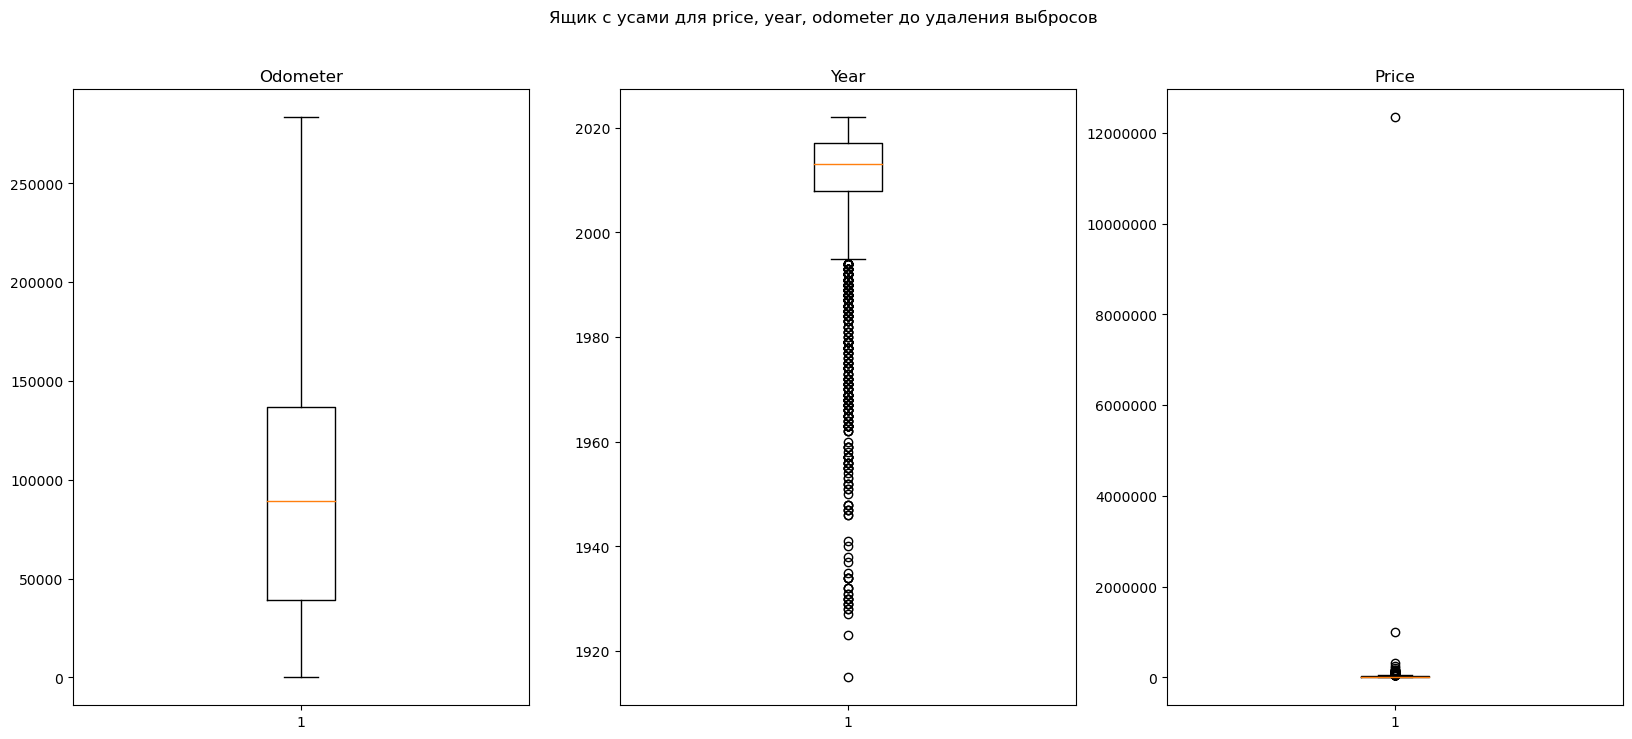

In [75]:
# Визуализация наличия выбросов

fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(20,8))

ax1.boxplot(df.odometer)
ax1.set_title('Odometer')

ax2.boxplot(df.year)
ax2.set_title('Year')

ax3.boxplot(df.price)
ax3.set_title('Price')

ax3.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
fig.suptitle('Ящик с усами для price, year, odometer до удаления выбросов')

- Выбросы в столбце "odometer" отсутствуют, все значения не выходят за пороги, определенные на основе интерквартильного размаха и квартилей.
- В столбце "year" имеются выбросы среди минимальных значений, верхний порог превышает максимальное значение, выбросов среди максимальных значений нет.
- В столбце "price" выбросы среди минимальных значений отсутствуют, верхний порог меньше максимального значения, имеются выбросы среди максимальных значений.

In [36]:
df_new = df.copy()

### Замена минимальных значений в year на нижний порог

In [37]:
df_new[outliers['year']]['price_category'].value_counts()

low       181
medium    135
high       78
Name: price_category, dtype: int64

In [38]:
df_new.loc[outliers['year'], 'year'] = int(boundaries[0]['year']+1)
df_new.year.describe()

count    9901.000000
mean     2011.723563
std         6.429371
min      1995.000000
25%      2008.000000
50%      2013.000000
75%      2017.000000
max      2022.000000
Name: year, dtype: float64

### Удаление строк с ценой, превышающей максимальный порог

In [39]:
df_new[outliers['price']]['year'].value_counts()

2019    56
2020    44
2017    26
2018    25
2016    15
2021     9
1995     8
2015     7
2014     4
2006     4
2004     3
2013     3
2010     2
2005     2
2011     1
2000     1
2009     1
2008     1
2007     1
2012     1
2022     1
Name: year, dtype: int64

In [40]:
df_new = df_new[~outliers['price']]
df_new.price.describe()

count     9686.000000
mean     18089.144022
std      12562.396896
min        500.000000
25%       7500.000000
50%      15000.000000
75%      26995.000000
max      57999.000000
Name: price, dtype: float64

## *Информация о DF после Data Preparation*

In [41]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9686 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype              
---  ------          --------------  -----              
 0   id              9686 non-null   int64              
 1   url             9686 non-null   object             
 2   region          9686 non-null   object             
 3   region_url      9686 non-null   object             
 4   price           9686 non-null   int64              
 5   year            9686 non-null   int32              
 6   manufacturer    9686 non-null   category           
 7   model           9686 non-null   object             
 8   fuel            9686 non-null   category           
 9   odometer        9686 non-null   int64              
 10  title_status    9686 non-null   category           
 11  transmission    9686 non-null   category           
 12  image_url       9686 non-null   object             
 13  description     9686 non-null   o

# 3. Feature engineering

## *Создание новых признаков*

In [43]:
df_feat_engin = df_new.copy()
df_feat_engin.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9686 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype              
---  ------          --------------  -----              
 0   id              9686 non-null   int64              
 1   url             9686 non-null   object             
 2   region          9686 non-null   object             
 3   region_url      9686 non-null   object             
 4   price           9686 non-null   int64              
 5   year            9686 non-null   int32              
 6   manufacturer    9686 non-null   category           
 7   model           9686 non-null   object             
 8   fuel            9686 non-null   category           
 9   odometer        9686 non-null   int64              
 10  title_status    9686 non-null   category           
 11  transmission    9686 non-null   category           
 12  image_url       9686 non-null   object             
 13  description     9686 non-null   o

### Создание признака age_category, обозначающего возрастную категорию автомобиля

- new  — автомобиль после 2013 года выпуска;
- average — автомобиль, выпущенный между 2006 и 2013 годом;
- old — автомобиль до 2006 года выпуска.

      year age_category
0     2020          new
1     2016          new
2     2017          new
3     2013      average
4     2021          new
...    ...          ...
9995  2002          old
9996  2008      average
9997  2011      average
9998  2015          new
9999  2017          new

[9686 rows x 2 columns]


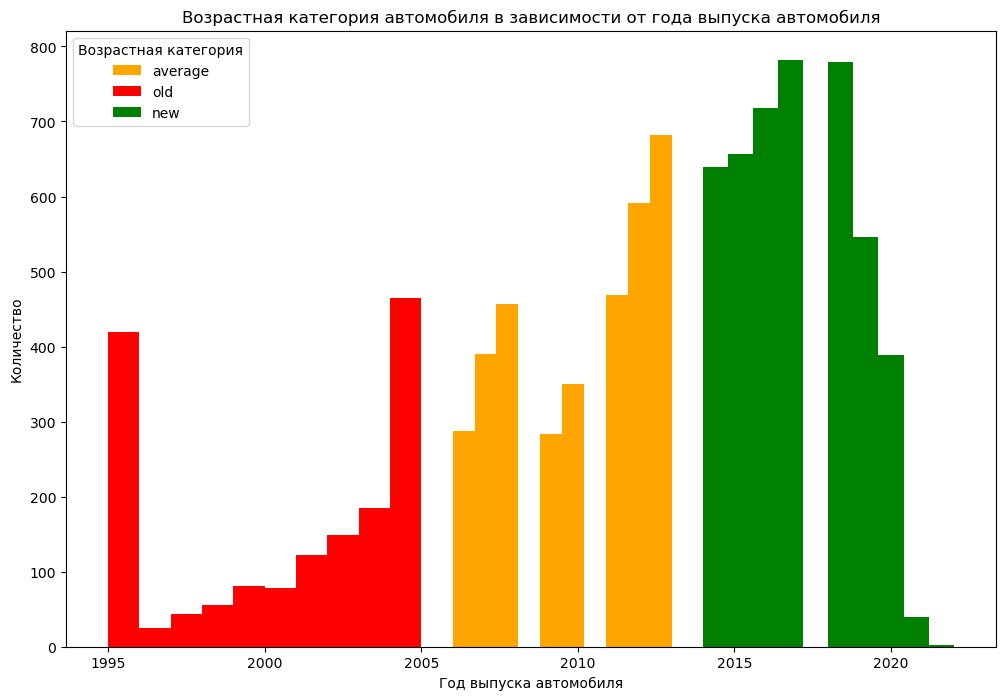

In [45]:
df_feat_engin['age_category'] =  df_feat_engin.apply(lambda x: "new" if x.year > 2013 else ("old" if x.year < 2006 else "average"), axis=1)
print(df_feat_engin[['year', 'age_category']])

colors = {'average': 'orange', 'old': 'red', 'new': 'green'}

fig, ax = plt.subplots(figsize=(12, 8))
for age_category in colors:
    color = colors[age_category]
    data = df_feat_engin[df_feat_engin['age_category'] == age_category]

    ax.hist(data['year'], color=color)
    
plt.ylabel('Количество')
plt.xlabel('Год выпуска автомобиля')
plt.title('Возрастная категория автомобиля в зависимости от года выпуска автомобиля')
plt.legend(colors, title="Возрастная категория");

### Создание признака short_model, обозначающего сокращённое название модели автомобиля

In [46]:
df_feat_engin['short_model'] = df_feat_engin['model'].apply(lambda x: x.split()[0])
df_feat_engin.short_model.value_counts()

silverado    393
1500         205
wrangler     205
grand        203
f-150        197
            ... 
FRRV           1
GRAND          1
blue           1
gx460          1
gs350          1
Name: short_model, Length: 963, dtype: int64

### Создание признака model_len, обозначающего длину наименования автомобиля

In [47]:
df_feat_engin['model_len'] = df_feat_engin.apply(lambda x: len(x.model) , axis=1)
df_feat_engin['model_len'].value_counts()

6      1009
5       904
7       729
8       687
4       650
       ... 
187       1
168       1
58        1
76        1
186       1
Name: model_len, Length: 65, dtype: int64

### Создание признака model_word_count, обозначающего количество слов в наименовании автомобиля

In [48]:
df_feat_engin['model_word_count'] = df_feat_engin.apply(lambda x: len(x.model.split(' ')), axis=1)
df_feat_engin['model_word_count'].value_counts()

1     4310
2     2215
3     1365
4     1186
5      499
6       68
10       8
8        7
11       5
9        5
7        4
13       3
15       3
27       1
21       1
14       1
17       1
24       1
12       1
29       1
22       1
Name: model_word_count, dtype: int64

### Создание признака month, обозначающего номер месяца, в котором было подано объявление о продаже атомобиля

In [49]:
df_feat_engin['month'] = df.posting_date.dt.month
df_feat_engin.month

0       4
1       5
2       4
3       4
4       5
       ..
9995    4
9996    5
9997    4
9998    4
9999    4
Name: month, Length: 9686, dtype: int64

### Создание признака dayofweek, обозначающего номер дня недели, в котором было подано объявление о продаже атомобиля

In [50]:
df_feat_engin['dayofweek'] = df_feat_engin.posting_date.dt.dayofweek
df_feat_engin.dayofweek 

0       5
1       0
2       2
3       5
4       0
       ..
9995    5
9996    0
9997    3
9998    2
9999    5
Name: dayofweek, Length: 9686, dtype: int64

### Создание признака diff_years, обозначающего  количество лет между годом производства автомобиля и годом размещения объявления о его продаже

In [51]:
df_feat_engin['diff_years'] = df_feat_engin.posting_date.dt.year - df_feat_engin.year
df_feat_engin.diff_years

0        1
1        5
2        4
3        8
4        0
        ..
9995    19
9996    13
9997    10
9998     6
9999     4
Name: diff_years, Length: 9686, dtype: int64

### Создание признака region_new, обозначающего регион одним словом

In [52]:
df_feat_engin['region_new'] = df_feat_engin.region_url.str.lower().str.split('://').str[1].str.split('.').str[0]
df_feat_engin.region_new

0        chattanooga
1          newjersey
2               reno
3       fayetteville
4            newyork
            ...     
9995      chautauqua
9996      binghamton
9997           salem
9998         madison
9999         norfolk
Name: region_new, Length: 9686, dtype: object

## *Подготовка категориальных переменных с помощью OneHotEncoder*

In [53]:
df_feat_engin.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9686 entries, 0 to 9999
Data columns (total 28 columns):
 #   Column            Non-Null Count  Dtype              
---  ------            --------------  -----              
 0   id                9686 non-null   int64              
 1   url               9686 non-null   object             
 2   region            9686 non-null   object             
 3   region_url        9686 non-null   object             
 4   price             9686 non-null   int64              
 5   year              9686 non-null   int32              
 6   manufacturer      9686 non-null   category           
 7   model             9686 non-null   object             
 8   fuel              9686 non-null   category           
 9   odometer          9686 non-null   int64              
 10  title_status      9686 non-null   category           
 11  transmission      9686 non-null   category           
 12  image_url         9686 non-null   object             
 13  des

In [54]:
# Cоздание датафрейма category_col, содержащего выбранные категориальные переменные

category_col = df_feat_engin[['manufacturer', 
                              'fuel', 
                              'title_status', 
                              'transmission', 
                              'state', 
                              'age_category', 
                              'short_model', 
                              'region_new']]
category_col.nunique()

manufacturer     40
fuel              5
title_status      6
transmission      3
state            51
age_category      3
short_model     963
region_new      405
dtype: int64

In [55]:
# Преобразование датафрейма и сохранение в новую переменную

ohe = OneHotEncoder(sparse=False)

ohe_transform = ohe.fit_transform(category_col)
ohe_transform.shape

C:\Users\user\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


(9686, 1476)

In [57]:
 # Добавление признаков в исходный датафрейм

df_feat_engin[ohe.get_feature_names_out()] = ohe_transform
df_feat_engin

,id,url,region,region_url,price,year,manufacturer,model,fuel,odometer,...,region_new_winchester,region_new_winstonsalem,region_new_worcester,region_new_wyoming,region_new_yakima,region_new_york,region_new_youngstown,region_new_yubasutter,region_new_yuma,region_new_zanesville
0,7308295377,https://chattanooga.craigslist.org/ctd/d/chatt...,chattanooga,https://chattanooga.craigslist.org,54990,2020,ram,2500 crew cab big horn,diesel,27442,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,7316380095,https://newjersey.craigslist.org/ctd/d/carlsta...,north jersey,https://newjersey.craigslist.org,16942,2016,ford,explorer 4wd 4dr xlt,other,60023,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,7313733749,https://reno.craigslist.org/ctd/d/atlanta-2017...,reno / tahoe,https://reno.craigslist.org,35590,2017,volkswagen,golf r hatchback,gas,14048,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,7308210929,https://fayetteville.craigslist.org/ctd/d/rale...,fayetteville,https://fayetteville.craigslist.org,14500,2013,toyota,rav4,gas,117291,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,7316474668,https://newyork.craigslist.org/lgi/cto/d/baldw...,new york city,https://newyork.craigslist.org,21800,2021,nissan,altima,gas,8000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,7304876387,https://chautauqua.craigslist.org/ctd/d/falcon...,chautauqua,https://chautauqua.craigslist.org,4495,2002,toyota,rav4,gas,150000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9996,7316152972,https://binghamton.craigslist.org/ctd/d/roches...,binghamton,https://binghamton.craigslist.org,14495,2008,jeep,wrangler,gas,113573,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9997,7310993818,https://salem.craigslist.org/ctd/d/salem-2011-...,salem,https://salem.craigslist.org,8995,2011,audi,a3 2.0t premium plus pzev,gas,150184,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9998,7306637427,https://madison.craigslist.org/ctd/d/madison-2...,madison,https://madison.craigslist.org,31900,2015,porsche,cayenne,hybrid,61943,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## *Стандартизация и нормализация переменных*

In [58]:
# Cоздание датафрейма quantitive_col, содержащего выбранные количественные переменные

quantitive_col = df_feat_engin[['year', 
                                'odometer', 
                                'lat', 
                                'long', 
                                'model_len', 
                                'model_word_count', 
                                'month', 
                                'dayofweek', 
                                'diff_years']]
quantitive_col

,year,odometer,lat,long,model_len,model_word_count,month,dayofweek,diff_years
0,2020,27442,35.060000,-85.250000,22,5,4,5,1
1,2016,60023,40.821805,-74.061962,20,4,5,0,5
2,2017,14048,33.779214,-84.411811,16,3,4,2,4
3,2013,117291,35.715954,-78.655304,4,1,4,5,8
4,2021,8000,40.654800,-73.609700,6,1,5,0,0
...,...,...,...,...,...,...,...,...,...
9995,2002,150000,42.123900,-79.189500,4,1,4,5,19
9996,2008,113573,43.216990,-77.755610,8,1,5,0,13
9997,2011,150184,44.925908,-122.982753,25,5,4,3,10
9998,2015,61943,43.029559,-89.397796,7,1,4,2,6


In [59]:
# Преобразование датафрейма и сохранение в новую переменную

std_scaler = StandardScaler()

std_scaler_transform = std_scaler.fit_transform(quantitive_col)
std_scaler_transform.shape

(9686, 9)

In [60]:
# Создание наименований для новых признаков и добавление признаков в исходный датафрейм

std_columns = ['year_std', 
               'odometer_std', 
               'lat_std', 
               'long_std', 
               'model_len_std', 
               'model_word_count_std', 
               'month_std', 
               'dayofweek_std', 
               'diff_years_std']

df_feat_engin[std_columns] = std_scaler_transform
df_feat_engin.head()

,id,url,region,region_url,price,year,manufacturer,model,fuel,odometer,...,region_new_zanesville,year_std,odometer_std,lat_std,long_std,model_len_std,model_word_count_std,month_std,dayofweek_std,diff_years_std
0,7308295377,https://chattanooga.craigslist.org/ctd/d/chatt...,chattanooga,https://chattanooga.craigslist.org,54990,2020,ram,2500 crew cab big horn,diesel,27442,...,0.0,1.308945,-1.067299,-0.617353,0.486630,1.166118,1.915479,-0.615778,1.121411,-1.308945
1,7316380095,https://newjersey.craigslist.org/ctd/d/carlsta...,north jersey,https://newjersey.craigslist.org,16942,2016,ford,explorer 4wd 4dr xlt,other,60023,...,0.0,0.684430,-0.549891,0.389140,1.112821,0.934712,1.239189,1.623962,-1.375024,-0.684430
2,7313733749,https://reno.craigslist.org/ctd/d/atlanta-2017...,reno / tahoe,https://reno.craigslist.org,35590,2017,volkswagen,golf r hatchback,gas,14048,...,0.0,0.840559,-1.280005,-0.841086,0.533543,0.471901,0.562900,-0.615778,-0.376450,-0.840559
3,7308210929,https://fayetteville.craigslist.org/ctd/d/rale...,fayetteville,https://fayetteville.craigslist.org,14500,2013,toyota,rav4,gas,117291,...,0.0,0.216043,0.359564,-0.502769,0.855733,-0.916531,-0.789679,-0.615778,1.121411,-0.216043
4,7316474668,https://newyork.craigslist.org/lgi/cto/d/baldw...,new york city,https://newyork.craigslist.org,21800,2021,nissan,altima,gas,8000,...,0.0,1.465074,-1.376052,0.359967,1.138134,-0.685126,-0.789679,1.623962,-1.375024,-1.465074


## *Формирование финального датасета  для моделирования*

In [62]:
# Создание переменной, содержащей наименование столбцов, которые необходимо удалить

columns_for_drop = ['url', 'model', 'region', 'region_url', 'image_url', 'description', 'posting_date', 'date']
columns_for_drop.extend(quantitive_col)
columns_for_drop.extend(category_col)
columns_for_drop

['url',
 'model',
 'region',
 'region_url',
 'image_url',
 'description',
 'posting_date',
 'date',
 'year',
 'odometer',
 'lat',
 'long',
 'model_len',
 'model_word_count',
 'month',
 'dayofweek',
 'diff_years',
 'manufacturer',
 'fuel',
 'title_status',
 'transmission',
 'state',
 'age_category',
 'short_model',
 'region_new']

In [63]:
 # Удаление лишних столбцов

df_for_modeling = df_feat_engin.drop(columns=columns_for_drop)
df_for_modeling

,id,price,price_category,manufacturer_acura,manufacturer_alfa-romeo,manufacturer_audi,manufacturer_bmw,manufacturer_buick,manufacturer_cadillac,manufacturer_chevrolet,...,region_new_zanesville,year_std,odometer_std,lat_std,long_std,model_len_std,model_word_count_std,month_std,dayofweek_std,diff_years_std
0,7308295377,54990,high,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.308945,-1.067299,-0.617353,0.486630,1.166118,1.915479,-0.615778,1.121411,-1.308945
1,7316380095,16942,medium,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.684430,-0.549891,0.389140,1.112821,0.934712,1.239189,1.623962,-1.375024,-0.684430
2,7313733749,35590,high,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.840559,-1.280005,-0.841086,0.533543,0.471901,0.562900,-0.615778,-0.376450,-0.840559
3,7308210929,14500,medium,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.216043,0.359564,-0.502769,0.855733,-0.916531,-0.789679,-0.615778,1.121411,-0.216043
4,7316474668,21800,medium,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.465074,-1.376052,0.359967,1.138134,-0.685126,-0.789679,1.623962,-1.375024,-1.465074
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,7304876387,4495,low,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-1.501374,0.879006,0.616595,0.825835,-0.916531,-0.789679,-0.615778,1.121411,1.501374
9996,7316152972,14495,medium,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-0.564601,0.300520,0.807540,0.906089,-0.453720,-0.789679,1.623962,-1.375024,0.564601
9997,7310993818,8995,low,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,-0.096214,0.881928,1.106061,-1.625262,1.513226,1.915479,-0.615778,0.122837,0.096214
9998,7306637427,31900,high,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.528301,-0.519400,0.774799,0.254479,-0.569423,-0.789679,-0.615778,-0.376450,-0.528301


In [64]:
#Запись преобразованного датафрейма в файл

df_for_modeling.to_csv('data/df_for_modeling.csv', index=False)

# 4. Modelling

## *Формирование датасета для обучения, инициализация фич и целевой переменной, разделение на трейн и тест*

In [65]:
df_for_modeling_prep = df_for_modeling.drop(['price', 'id'], axis=1)

x = df_for_modeling_prep.drop(['price_category'], axis=1)
y = df_for_modeling_prep['price_category']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

## *Объявление моделей*

In [67]:
logreg = LogisticRegression(random_state=42)
rf = RandomForestClassifier(random_state=42)
mlp = MLPClassifier(random_state = 42)
models = [logreg, rf, mlp]
models

[LogisticRegression(random_state=42),
 RandomForestClassifier(random_state=42),
 MLPClassifier(random_state=42)]

## *Кросс-валидация на тренировочной выборке, выбор лучшей модели*

In [69]:
#Функция для вывода точностей на тестовых фолдах

def cv_scores(models):
    for model in models:
        cv_score = cross_val_score(model, x_train, y_train, cv=5)
        print('Точность на тестовых фолдах в ', model, ': ', cv_score, 'среднее значение: ', cv_score.mean(), 'стандартное отклонение: ', cv_score.std())

In [70]:
#вывод точностей на тестовых фолдах

cv_scores(models)

C:\Users\user\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\user\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

Точность на тестовых фолдах в  LogisticRegression(random_state=42) :  [0.73820059 0.74115044 0.75884956 0.75442478 0.7699115 ] среднее значение:  0.7525073746312685 стандартное отклонение:  0.011665911465065017
Точность на тестовых фолдах в  RandomForestClassifier(random_state=42) :  [0.74557522 0.72787611 0.75       0.74557522 0.74926254] среднее значение:  0.7436578171091446 стандартное отклонение:  0.008100017827578765


C:\Users\user\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\user\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Точность на тестовых фолдах в  MLPClassifier(random_state=42) :  [0.75884956 0.75884956 0.75368732 0.75368732 0.76179941] среднее значение:  0.7573746312684366 стандартное отклонение:  0.0031975639216340478


## *Тюнинг моделей*

In [71]:
logreg_tun = LogisticRegression(solver='saga', 
                                penalty='l1', 
                                max_iter=1200, 
                                C=10,
                                random_state=42)

rf_tun = RandomForestClassifier(n_estimators = 400, 
                                min_samples_leaf = 1, 
                                max_features = 'log2', 
                                random_state=42)

mlp_tun = MLPClassifier(solver='sgd', 
                        max_iter=1300, 
                        learning_rate_init=0.001, 
                        learning_rate='adaptive', 
                        hidden_layer_sizes=50, 
                        early_stopping=False, 
                        batch_size='auto', 
                        alpha=0.0001,
                        activation='tanh',
                        random_state = 42)

models_tun = [logreg_tun, rf_tun, mlp_tun]

In [73]:
cv_scores(models_tun)

C:\Users\user\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\user\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\user\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\user\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\user\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Точность на тестовых фолдах в  LogisticRegression(C=10, max_iter=1200, penalty='l1', random_state=42,
                   solver='saga') :  [0.75073746 0.74926254 0.76622419 0.75663717 0.77286136] среднее значение:  0.7591445427728613 стандартное отклонение:  0.009087269498967175
Точность на тестовых фолдах в  RandomForestClassifier(max_features='log2', n_estimators=400, random_state=42) :  [0.74926254 0.74041298 0.76327434 0.75       0.75294985] среднее значение:  0.7511799410029498 стандартное отклонение:  0.007353953311102019


C:\Users\user\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1300) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\user\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1300) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\user\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1300) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\user\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1300) reached and the optimization hasn't converged yet.
  warnings.warn(


Точность на тестовых фолдах в  MLPClassifier(activation='tanh', hidden_layer_sizes=50,
              learning_rate='adaptive', max_iter=1300, random_state=42,
              solver='sgd') :  [0.77138643 0.7699115  0.7780236  0.77654867 0.7839233 ] среднее значение:  0.7759587020648968 стандартное отклонение:  0.0050104093662132745


C:\Users\user\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1300) reached and the optimization hasn't converged yet.
  warnings.warn(


## *Расчет метрики на лучшей модели*

In [77]:
mlp_tun.fit(x_train, y_train)



print(f'качество на трейне: {accuracy_score(mlp_tun.predict(x_train), y_train)}')
print(f'качество на тесте: {accuracy_score(mlp_tun.predict(x_test), y_test)}')
confusion_matrix(mlp_tun.predict(x_test), y_test)

C:\Users\user\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1300) reached and the optimization hasn't converged yet.
  warnings.warn(


качество на трейне: 0.891740412979351
качество на тесте: 0.7900894700619409


array([[827,  18, 121],
       [ 23, 765, 164],
       [123, 161, 704]], dtype=int64)

Модель хорошо обучилась на тренировочной выборке, на тестовой качество просело на одну десятую. Результат метрики хороший, модель сохраняет свою предиктивную способность. 
Модель не переобучена

# 5. Results

Mодель mlp_tun показала себя лучше всего

In [78]:
#Обучение модели mlp_tun на всем датасете

mlp_tun.fit(x, y)

print(f'качество на всем датасете: {accuracy_score(mlp_tun.predict(x), y)}')

качество на всем датасете: 0.8978938674375387


C:\Users\user\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1300) reached and the optimization hasn't converged yet.
  warnings.warn(


In [79]:
#Сохранение обученной модели в pickle

filename = 'mlp_result.pickle'

with open(filename, 'wb') as file:
    pickle.dump(mlp_tun, file)